# Capstone Project - The Battle of Neighborhoods
### Restaurants at Brussels Captical Region
### Applied Data Science Capston @ Coursera
#### Michael Fan

## I. Introduction

I am interested in restaurants in Brussels, Belgium because of personal connection to Auderghem. Auderghem is a municipality in Brussels Capital Region. Furthermore, I am interested in knowing more about Japanese restaurant in that region, because it was known that (https://en.wikipedia.org/wiki/Auderghem) as of 2004 the majority of Brussels' Japanese expatriate population lives in Auderghem. I have never been to Brussels, nor do I speak French. It will be interesting in learning about that region given the knowledge, skills, and tools I have developed from this course so far. It will be intersting to utilize the database provided by Foursquare.com API and other sources that I can access through interent.

It is generally known that number of restaurants and types of restaurants are closely related to demographics in a region. When expats feel home sick, eating some food resembled to home is best to heal it. Will the data show that?



## II. Data

Since I am interested in data of restaurants at Brussels Capital Region, I will be using Foursquare API to collect venue information. The intent is to analyze the data for different types of restaurants at different locations. Foursquare venue category ID hierachical information will be collected and analyzed. Tools will be developed to access information from the database. Demograhic information from https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region will be scraped into the dataset. Geojason information of Brussels Capital Region from http://geoservices-urbis.irisnet.be/geoserver/Urbis/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=Urbis:Mu&outputFormat=JSON&srsName=EPSG:4326&maxFeatures=100 for municipality boundaries will be used in the analysis. Finally, Google MAP API will be used to obtain address information from geographical coordinated obtained from Foursquare query. 

In the following, I will show the data I have collected and demonstrate how it may be used in my analysis.


### Collect data for whole Brussels Capital Region


In [2]:
import requests
import pandas as pd
import folium
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math
from time import sleep

google_api_key=''
foursquare_client_id = '' # your Foursquare ID
foursquare_client_secret=''
foursquare_version = '20180605' # Foursquare API version
    



#### Basic information about Brussels Captical Region

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

try:
    df=pd.read_pickle('./brussels_muni_postcodes3.pkl')
    print('brussels_muni_postcodes3.pkl loaded')
except:
    print('Run the code of the next cells to scrape data again')
    
    
df.head()

brussels_muni_postcodes3.pkl loaded


municipality           Dutch name             postcode  \
0             Anderlecht           Anderlecht                 1070   
1              Auderghem             Oudergem                 1160   
2  Berchem-Sainte-Agathe  Sint-Agatha-Berchem                 1082   
3        Bruxelles-Ville         Stad Brussel  1000,1020,1120,1130   
4              Etterbeek            Etterbeek                 1040   

  Population(1/1/2017)                       Area Population density(km²)  \
0              118,241   17.717.7 km2 (6.8 sq mi)                   6,680   
1               33,313    09.09.0 km2 (3.5 sq mi)                   3,701   
2               24,701    02.92.9 km2 (1.1 sq mi)                   8,518   
3              176,545  32.632.6 km2 (12.6 sq mi)                   5,415   
4               47,414    03.13.1 km2 (1.2 sq mi)                  15,295   

   population    area  populationDensity  
0      118241  17.717               6680  
1       33313   9.090               3701  
2       24701   2.920               8518  
3      176545  32.632               5415  
4       47414   3.130              15295

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import pickle


source=requests.get('https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region').text
soup=BeautifulSoup(source,'lxml')

table=soup.find('table', class_='wikitable sortable')
table_body=table.tbody

colNames=['municipality', 'Dutch name', 'postcode', 'Population(1/1/2017)', 'Area', 'Population density(km²)']
data=[[col.text.strip().strip('*') for col in row.find_all('td')] for row in table_body.find_all('tr') if row.find('td')]

df_muni=pd.DataFrame(data)


df_muni.drop([0,3,4], axis=1,inplace=True)

df_muni.columns=colNames

df_muni['postcode']=df_muni.apply(lambda r: ",".join(re.findall('\d{4}',r[2])),axis=1)
df_muni['population']=df_muni.apply(lambda r: int(r[3].replace(',','')),axis=1)
df_muni['area']=df_muni.apply(lambda r: float(re.search('0*(.*\..*)\..*km2', r[4]).group(1)), axis=1)
df_muni['populationDensity']=df_muni.apply(lambda r: int(r[5].replace(',','')),axis=1)

df_muni.head()

#fName='brussels_muni_postcodes3.pkl'
#df_muni.to_pickle(fName)

municipality           Dutch name             postcode  \
0             Anderlecht           Anderlecht                 1070   
1              Auderghem             Oudergem                 1160   
2  Berchem-Sainte-Agathe  Sint-Agatha-Berchem                 1082   
3        Bruxelles-Ville         Stad Brussel  1000,1020,1120,1130   
4              Etterbeek            Etterbeek                 1040   

  Population(1/1/2017)                       Area Population density(km²)  \
0              118,241   17.717.7 km2 (6.8 sq mi)                   6,680   
1               33,313    09.09.0 km2 (3.5 sq mi)                   3,701   
2               24,701    02.92.9 km2 (1.1 sq mi)                   8,518   
3              176,545  32.632.6 km2 (12.6 sq mi)                   5,415   
4               47,414    03.13.1 km2 (1.2 sq mi)                  15,295   

   population    area  populationDensity  
0      118241  17.717               6680  
1       33313   9.090               3701  
2       24701   2.920               8518  
3      176545  32.632               5415  
4       47414   3.130              15295

#### Foursquare category venue ID database
Functions to explore Foursquare category venue ID database. The dataset is assigned to GATEWAY4S, which has a data structure of list of dictionaries of list and ..... . The following are functions developed to access information from GATEWAY4S.

In [15]:
import pandas as pd
import requests
import json


try:
    with open('FoursquareVenuesIDdatabase.json') as infile:
        GATEWAY4S=json.load(infile)
    print('FoursquareVenuesIDdatabase.json loaded into GATEWAY4S')
except:
    results=requests.get('https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(foursquare_client_id, foursquare_client_secret, foursquare_version)).json()
    GATEWAY4S=results['response']['categories']
    #with open('FoursquareVenuesIDdatabase.json', 'w') as outfile:
    #    json.dump(GATEWAY4S, outfile)

FoursquareVenuesIDdatabase.json loaded into GATEWAY4S


In [16]:
def find_venueC_id(keyword, gateway=GATEWAY4S, level=1):
    
    l_currentlevel=[(v['name'], v['id'], level, len(v['categories'])==0) for v in gateway if keyword.lower() in v['name'].lower() ]
    
    l_lowerlevel=[]
    resultLowerLevel=[]
    for v in gateway:
        l_lowerlevel=find_venueC_id(keyword, v['categories'], level+1)
        if len(l_lowerlevel):
            resultLowerLevel.extend(l_lowerlevel)
    
    result=[]
    if len(l_currentlevel):
        result.extend(l_currentlevel)
    if len(resultLowerLevel):
        result.extend(resultLowerLevel)
        
    return result # name, id, level from root gateway, no (sub-)categories T/F
   
            

print("Venue category ID that includes keyword 'Japan': ", find_venueC_id('Japan'))

def find_venueC_path(vid, gateway=GATEWAY4S, l =None):
    for v in gateway:
        if vid==v['id'] :
            return [v['name']]
        else:
            l=[v['name']]
            result=find_venueC_path(vid,v['categories'],l)
            if result!=None:
                return [v['name'],*result]
    return None
        
        
            
print()       
print("For a given venue category ID, 4bf58dd8d48988d111941735, the path from root to it:")
print(find_venueC_path('4bf58dd8d48988d111941735'))
print()

def find_gateway_to_categories(venue, gateway=GATEWAY4S):
    result=find_venueC_id(venue)
   
    lpath=find_venueC_path(result[0][1])
    
    for vname in lpath:
        gateway_vnames=[v['name'] for v in gateway]
        gateway=gateway[gateway_vnames.index(vname)]['categories']
    return gateway

#find_venueC_id("Japanese Restaurant")
gateway=find_gateway_to_categories("Japanese Restaurant")
gateway[0]
print("For a given venue category, Japanese Restaurant, obtain the collection of data of its subcategories: ")
print('gateway=find_gateway_to_categories("Japanese Restaurant")')
print()

def find_subcategories_of_venueC(venue, gateway=GATEWAY4S):
    gateway=find_gateway_to_categories(venue)
    
    lvenues=[]
    if len(gateway):
        lvenues=[v['name'] for v in gateway]
        for v in lvenues:
                l2venues=find_subcategories_of_venueC(v)
                if l2venues:
                    lvenues.extend(l2venues)
    
    if len(lvenues):
        return lvenues
    
print("For a given category, Japanese Restaurant, its subcategories are: ")
print(find_subcategories_of_venueC('Japanese Restaurant'))
print()

def vid_all_categories(venue, gateway=GATEWAY4S):
    vidmain=find_venueC_id(venue)[0][1]
    l={find_venueC_id(vname)[0][1] for vname in find_subcategories_of_venueC(venue)}
    l.add(vidmain)
    return l

print("Given a venue category, Japanese Restaurant, the venue id of its subcategories are: ")
print(vid_all_categories('Japanese Restaurant'))




Venue category ID that includes keyword 'Japan':  [('Japanese Restaurant', '4bf58dd8d48988d111941735', 3, False), ('Japanese Curry Restaurant', '55a59bace4b013909087cb30', 4, True)]

For a given venue category ID, 4bf58dd8d48988d111941735, the path from root to it:
['Food', 'Asian Restaurant', 'Japanese Restaurant']

For a given venue category, Japanese Restaurant, obtain the collection of data of its subcategories: 
gateway=find_gateway_to_categories("Japanese Restaurant")

For a given category, Japanese Restaurant, its subcategories are: 
['Donburi Restaurant', 'Japanese Curry Restaurant', 'Kaiseki Restaurant', 'Kushikatsu Restaurant', 'Monjayaki Restaurant', 'Nabe Restaurant', 'Okonomiyaki Restaurant', 'Ramen Restaurant', 'Shabu-Shabu Restaurant', 'Soba Restaurant', 'Sukiyaki Restaurant', 'Sushi Restaurant', 'Takoyaki Place', 'Tempura Restaurant', 'Tonkatsu Restaurant', 'Udon Restaurant', 'Unagi Restaurant', 'Wagashi Place', 'Yakitori Restaurant', 'Yoshoku Restaurant']

Given a venu

### Create small blocks to cover the region of interest

Since there is limitation of the amount of data obtained through Foursqaure API query, small blocks that cover the region are created. Foursqaure API query is performed for each block.


#### Geojason for municipality boundary in Brussels Capital Region.

In [7]:
try:
    with open('Brussels_Municipalites.geojson') as fh:
        brusselsMuniGeojson=json.load(fh)
    print('Brussels_Municipalites.geojson loaded')
except:
    url='http://geoservices-urbis.irisnet.be/geoserver/Urbis/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=Urbis:Mu&outputFormat=JSON&srsName=EPSG:4326&maxFeatures=100'
    brusselsMuniGeojson=requests.get(url).json()

Brussels_Municipalites.geojson loaded


####  Create small blocks to cover the region

The following functions are modified from the source if necessary: https://cocl.us/coursera_capstone_notebook

In [8]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat): 
    '''convert (longitude, latitude) of WGS84 spherical coordinate system to (x,y coordinates in metters) of UTM Cartesian coordinate.'''
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    '''convert (x,y coordinates in metters) of UTM Cartesian coordinate to longitude, latitude) of WGS84 spherical coordinate system'''
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    '''Calculate distance between two coordinates (x1,y1) and (x2,y2) in meters'''
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

def createBlocks(center_x, center_y, dx, width, height):
    dy=dx
    k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
    steprange=int((2*width//dx+1)/k)  # for width=6000, dx=600, steprange=int(21/k)
    steprangeY=int((2*height//dy+1)/k)
    x_min = city_center_x - 6000
    x_min = city_center_x - width
    x_step = 600
    x_step = dx
    y_min = city_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
    y_min = city_center_y - height - (steprangeY*k*dy - 2*width)/2
    y_step = 600 * k
    y_step = dx * k 

    latitudes = []
    longitudes = []
    distances_from_center = []
    xs = []
    ys = []
    #for i in range(0, int(21/k)):
    for i in range(0, steprangeY):
        y = y_min + i * y_step
        x_offset = 300 if i%2==0 else 0
        x_offset = dx/2 if i%2==0 else 0
        #for j in range(0, 21):
        for j in range(0, steprange):
            x = x_min + j * x_step + x_offset
            distance_from_center = calc_xy_distance(city_center_x, city_center_y, x, y)
            #if (distance_from_center <= 6001):
            if (distance_from_center <= (width+1)):
                lon, lat = xy_to_lonlat(x, y)
                latitudes.append(lat)
                longitudes.append(lon)
                distances_from_center.append(distance_from_center)
                xs.append(x)
                ys.append(y)
    return latitudes, longitudes, distances_from_center, xs, ys
    

In [9]:
import requests
import pandas as pd
import folium
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

def get_coordinates(address, api_key=google_api_key, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except Exception as eObj:
        print(str(eObj))
        return [None, None]


brussels_address='Brussels, Belgium'

brussels_coord = get_coordinates(brussels_address)
print('Coordinate of {}: {}'.format(brussels_address, brussels_coord))

Coordinate of Brussels, Belgium: [50.8503463, 4.3517211]


Adjust the center and size of coverage so that regions of interest are all covered.

In [10]:
city_center=brussels_coord  # Brussels
city_center_x, city_center_y = lonlat_to_xy(city_center[1], city_center[0]) # City center in Cartesian coordinates
city_center_x+=900
city_center_y-=1600
latitudes, longitudes, distances_from_center, xs, ys=createBlocks(city_center_x, city_center_y, 600, 9600, 9000)

In [11]:
import folium
map_brussels = folium.Map(location=brussels_coord, zoom_start=12)

style = {'fillColor': '#00000000', 'color': 'red', 'weight': 5}
folium.GeoJson(brusselsMuniGeojson, style_function=lambda x: style).add_to(map_brussels)

for lat, lon, i in zip(latitudes, longitudes, range(len(latitudes))):
    label = '{}'.format(i)
    label = folium.Popup(label, parse_html=True)
    folium.Circle([lat, lon], radius=300, popup=label, color='blue', weight=3,fill=False).add_to(map_brussels)

map_brussels





The whole region of interest is divided into small blocks. Data will be queried for each block so that collection of the data of the whole region is detailed or consistent.

Saving the blocks information to a file:

In [12]:
import pickle

fName='brusselsCapitalRegion_coverageBlocks_coord.pkl'
df_blocks=pd.DataFrame([[lat, lon, d, x, y] for lat, lon, d, x, y in zip(latitudes, longitudes, distances_from_center, xs, ys)])

df_blocks.columns=['latitudes', 'longitudes', 'distances_from_center', 'xs', 'ys']

#with open(fName, 'wb') as poutfile:
#    df_blocks.to_pickle(poutfile)

df_blocks=pd.read_pickle(fName)
df_blocks.head()

latitudes  longitudes  distances_from_center             xs            ys
0  50.757280    4.330415            9345.885721 -251692.165521  5.677324e+06
1  50.758053    4.338774            9111.837351 -251092.165521  5.677324e+06
2  50.758826    4.347134            8912.103002 -250492.165521  5.677324e+06
3  50.759599    4.355494            8749.033084 -249892.165521  5.677324e+06
4  50.760370    4.363854            8624.707526 -249292.165521  5.677324e+06

#### Determine which venture category ID(s) to use to query data from Foursqaure.com

Keyword for the venue category ID is 'Restaurant'.

In [13]:
lvenueC_allRestaurants=find_venueC_id("Restaurant")

Foursquare will return data for the querried venue category ID and its subcategories. Remove those category ID's that their parent category is already included in the list:

In [14]:
lvenueC_allRestaurants.sort(reverse=True, key=lambda v:v[2])
i=0

while i<len(lvenueC_allRestaurants):

    v=lvenueC_allRestaurants[i]
    vpath=find_venueC_path(v[1])
    if vpath[-2] in [i[0] for i in lvenueC_allRestaurants]:
        #print("removing", v[0], "because it's a category of venue", vpath[-2])
        lvenueC_allRestaurants.pop(i)
    else:
        i+=1

The list, lvenueC_allRestaurants, can be used to create a string containing a list of categoryID's to be used in Foursquare.com query of any given number of size. Depending on data acquision method, either a generator or a list of string out of lvenueC_allRestaurants can surve the purpose.

Even though Foursquare allows supplying a list of category ID's for each query. Shorter list seems provide more detailed and consistent data. If longer list is provided, it seems Foursquare uses certain algorithm to determine data in response. Sometimes it may introduce more noise than necessary in the data collected. For data collection in this work, one categoryID is provided in each query. 


A generator of categoryID string to be used for Foursquare.com query:

In [15]:
size=1
categoryID=(",".join([v[1] for v in lvenueC_allRestaurants[i:i+size]]) for i in range(0,len(lvenueC_allRestaurants),size))

A list of categoryID string to be used for Foursquare.com query:

In [17]:
size=1
categoryID=[",".join([v[1] for v in lvenueC_allRestaurants[i:i+size]]) for i in range(0,len(lvenueC_allRestaurants),size)]

#### Collect Data for each block from Foursquare.com

In [18]:
import requests
import pandas as pd
import folium
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from time import sleep


   
def query4sq(lat, lon, cid, radius=300, limit=50, client_id=foursquare_client_id, client_secret=foursquare_client_secret, version=foursquare_version):
    lrestaurants=[]
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            client_id, client_secret, version, lat, lon, cid, radius, limit)

    retry=0
    while retry<10:
        try:
            results=requests.get(url).json()
            #print(results)
            if results['meta']['code'] in {400, 401, 403, 404, 429}:
                print('query: '+url)
                print(results['meta']['errorDetail'])
                raise SystemExit
            print('.', end='')
            retry=10
        except requests.exceptions.ConnectionError as eObj:
            print("Connection Error: "+str(eObj))
            print("sleep for 5 seconds and retry.")
            sleep(5)
            retry+=1
            if retry==10:
                return 'NaN'

        except Exception as eObj:
            print("Request error from Foursquare, yielding NaN as data")
            print("error: "+str(eObj))
            sleep(5)
            rety+=1
            if retry==10:
                return 'NaN'
        
    try:

        l=[(v['venue']['id'], v['venue']['name'],
            v['venue']['location']['lat'], v['venue']['location']['lng'],
            v['venue']['location']['distance'], v['venue']['location']['formattedAddress'],v['venue']['categories']) for v in results['response']['groups'][0]['items']]
        
    
        print('*',end='')

    except Exception as eObj: 
        print("something wrong with the querried data.")
        print(str(eObj))
        l=[]
    
    
    return l


    

In [19]:
import pickle, calendar, time

  
def collectData(latitudes,longitudes, categoryID, memo=None):
    print("...", foursquare_client_id, foursquare_client_secret)
    try:
        for lat,lon in zip(latitudes, longitudes):
            #print(lat,lon)
            for cid in categoryID:  # In case single categoryID, not a list
                key=(lat,lon,cid)
                if key not in memo:
                    print('acquiring data...')
                    result=query4sq(lat,lon,cid)
                    memo[key]=result
                    
                print(key," : ",memo[key])
                
        fName="collectData_"+str(calendar.timegm(time.gmtime()))+".pkl"
        print("Saving data to: "+fName)
        with open(fName,"wb") as poutfile:
            pickle.dump(data, poutfile)
            
    except Exception as eObj:
        fName="collectData_exceptionDump_"+str(calendar.timegm(time.gmtime()))+".pkl"
        print(str(eObj))
        print("Saving data to: "+fName)
        with open(fName,"wb") as poutfile:
            pickle.dump(data, poutfile)
    

#### Initial Data Acquisition
Acquired data are stored in a dictionary, data, with **key=(lat, lon, categoryID)**

In [ ]:
data={}  # note: First attemp to acquire the data. Supplying an empty dict to store the acquired data.

size=1
start_block=0
end_block=len(latitudes)

categoryID=[",".join([v[1] for v in lvenueC_allRestaurants[i:i+size]]) for i in range(0,len(lvenueC_allRestaurants),size)]

collectData(latitudes[start_block:end_block], longitudes[start_block:end_block],categoryID,memo=data)

If data acquisitioin caught exception, save it to a file.

In [91]:
import pickle, calendar, time

fName="dataDump_"+str(calendar.timegm(time.gmtime()))+".pkl"
        
#with open(fName,"wb") as poutfile:
#    pickle.dump(data, poutfile)

Restart a new data collection process. Keeping the same data{} for data dump or load the dataDump file

In [94]:
with open(fName,"rb") as pinfile:
    data=pickle.load(pinfile)

In [ ]:
size=1
start_block=0
end_block=len(latitudes)

categoryID=[",".join([v[1] for v in lvenueC_allRestaurants[i:i+size]]) for i in range(0,len(lvenueC_allRestaurants),size)]

collectData(latitudes[start_block:end_block], longitudes[start_block:end_block],categoryID,memo=data)

#### Saving the data
Data acquisitioin finally completed the first time. Saving to a file.

In [20]:
import pickle

#with open("data_firstWholeDump_0909_26Apr2019.pkl","wb") as poutfile:
#    pickle.dump(data, poutfile)

### Prepare the Data

#### Create DataFrame from acquired data

In [14]:
import pickle

fName='data_firstWholeDump_0909_26Apr2019.pkl'

with open(fName,"rb") as pinfile:
    data=pickle.load(pinfile)

In [13]:
data

Some query yields empty results. Remove those from the data

Prepare a list of keys to be removed from the data.

Remove empty entries from data.

In [6]:
ldelete=[key for key,value in data.items() if value==[]]
for key in ldelete:
    data.pop(key)


Create data frame.

Drop duplicate venue ID's, set column names, reset row index

In [7]:
df_restaurants_brussels_raw=pd.DataFrame((row for l in data.values() for row in l))
df_restaurants_brussels_raw['venueCategory']=df_restaurants_brussels_raw.apply(lambda r: r[6][0]['name'], axis=1)
df_restaurants_brussels_raw['venueCategoryID']=df_restaurants_brussels_raw.apply(lambda r: r[6][0]['id'], axis=1)
df_restaurants_brussels_raw.drop(labels=[4,6],axis=1, inplace=True)   # distance from block center is removed
df_restaurants_brussels_raw.columns=['vid','name','latitude','longitude','address','venueCategory','venueCategoryID']
                   
df_restaurants_brussels_raw.drop_duplicates('vid', inplace=True)
df_restaurants_brussels_raw.reset_index(inplace=True)
df_restaurants_brussels_raw.drop('index', axis=1, inplace=True)

df_restaurants_brussels_raw.head()

#### Get postal codes from Google Map api using latitudes and longitudes.

The primary purpose of post code is to assign venue the municipality it belongs to.

The format of address provided by Foursquare.com query is not consistent. Using post codes is easier.

In [3]:
import pickle

def get_address(api_key, latitude, longitude, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&latlng={},{}'.format(api_key, latitude, longitude)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address = results[0]['formatted_address']
        return address
    except:
        return None
def get_postcode(api_key, latitude, longitude, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&latlng={},{}'.format(api_key, latitude, longitude)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address=results[0]['formatted_address']
        postcode = address.split(',')[1].strip().split()[0]
        if not( postcode.isdigit() and len(postcode)==4):
            postcode = address.split(',')[-2].strip().split()[0]
        print('.', end='')
        return postcode
    except:
        print('*', end='')
        return 'NaN'

try:
    fName='dataDF_wPostCode_0909_26Apr2019_28Apr2019.pkl'
    
    df_restaurants_brussels_raw=pd.read_pickle(fName)
    print(fName+' loaded.')
except Exception as eObj:
    #df_restaurants_brussels_raw['postcode']=df_restaurants_brussels_raw.apply(lambda r: get_postcode(google_api_key, r[2], r[3], verbose=False), axis=1 )
    print('error: '+str(eObj))



dataDF_wPostCode_0909_26Apr2019_28Apr2019.pkl loaded.


In [4]:
df_restaurants_brussels_raw.head()

vid                  name   latitude  longitude  \
0  5241d59b11d26a2a08e25c24               Pastaga  50.756677   4.331686   
1  58e88778b210143737a1ade0  Boulangerie Gandossi  50.756441   4.332156   
2  4dea8a8a7d8b6c7a5342555c           't Hoogveld  50.755183   4.331853   
3  55782108498efe736ee03620       Terasse Tessaro  50.760301   4.374671   
4  575bfdcd498e1d5197ab9d7a        Salle à manger  50.761991   4.372160   

                                         address       venueCategory  \
0                                       [België]  Italian Restaurant   
1                         [1652 Beersel, België]              Bakery   
2  [alsembergsesteenweg, 1630 Linkebeek, België]          Restaurant   
3                                       [België]              Buffet   
4              [1640 Sint-Genesius-Rode, België]              Bistro   

            venueCategoryID postcode  
0  4bf58dd8d48988d110941735     1652  
1  4bf58dd8d48988d16a941735     1652  
2  4bf58dd8d48988d1c4941735     1652  
3  52e81612bcbc57f1066b79f4     1640  
4  52e81612bcbc57f1066b79f1     1640

Some entries do not have postcode:

In [5]:
df_restaurants_brussels_raw[~df_restaurants_brussels_raw['postcode'].str.isnumeric()].head()

vid                 name   latitude  longitude  \
927   5a3416f5d69ed0089fd526d8               Makisu  50.822720   4.353689   
945   4b58614ff964a520235528e3            L'Atelier  50.822689   4.353777   
2917  4dcf84f9d4c065592f9abd07  La Boite à Tartines  50.847808   4.408432   
3317  4bb4c879a70595215aab1bce           Le Liberty  50.849771   4.366524   
3362  4bf7b8544a67c9284a1024cf          Garden City  50.849795   4.366455   

                                                address     venueCategory  \
927   [Chaussée de Waterloosesteenweg 361, 1060 Sint...  Sushi Restaurant   
945      [Av. Brugmannlaan 2, 1060 Sint-Gillis, België]    Sandwich Place   
2917  [Square Levie 2, 1200 Brussel (Sint-Lambrechts...            Bakery   
3317  [Pl. de la Liberté 7 Vrijheidspl., 1000 Brusse...              Café   
3362  [Vrijheidsplein 6 Place de la Liberté, 1000 Br...        Restaurant   

               venueCategoryID postcode  
927   4bf58dd8d48988d1d2941735       Ma  
945   4bf58dd8d48988d1c5941735       Ma  
2917  4bf58dd8d48988d16a941735    Levie  
3317  4bf58dd8d48988d16d941735  Brussel  
3362  4bf58dd8d48988d1c4941735  Brussel

Remove rows with empty post code data. 

In [6]:
df_restaurants_brussels=df_restaurants_brussels_raw[df_restaurants_brussels_raw['postcode'].apply(lambda x: isinstance(x, str) and x.isdigit())]

print('df_restaurants_brussels dimension: ',df_restaurants_brussels.shape)
print('df_restaurants_brussels_raw dimension: ',df_restaurants_brussels_raw.shape)
print(f'Percentage of good postcode data: {df_restaurants_brussels.shape[0]/df_restaurants_brussels_raw.shape[0]*100:.2f}%')
print('Unique post codes in the data: ',df_restaurants_brussels['postcode'].unique())

df_restaurants_brussels dimension:  (5088, 8)
df_restaurants_brussels_raw dimension:  (5101, 8)
Percentage of good postcode data: 99.75%
Unique post codes in the data:  ['1652' '1640' '1560' '1630' '1180' '1650' '1651' '1170' '3090' '1601'
 '1620' '1160' '1600' '1000' '1190' '1050' '3080' '1070' '1150' '1060'
 '1040' '1970' '1602' '1701' '1200' '1950' '1047' '1700' '1030' '1210'
 '1080' '1043' '1140' '1932' '1081' '1930' '1082' '1090' '1702' '1083'
 '1020' '1130' '1831' '2060' '1731' '1120' '1830' '1780' '1853' '1800'
 '1850']


99.75% of collected data have good postal code information for analysis after filtering.

#### Adding municipality to data according to postcode

In [7]:
df_muni=pd.read_pickle('brussels_muni_postcodes3.pkl')
df_muni.head()

municipality           Dutch name             postcode  \
0             Anderlecht           Anderlecht                 1070   
1              Auderghem             Oudergem                 1160   
2  Berchem-Sainte-Agathe  Sint-Agatha-Berchem                 1082   
3        Bruxelles-Ville         Stad Brussel  1000,1020,1120,1130   
4              Etterbeek            Etterbeek                 1040   

  Population(1/1/2017)                       Area Population density(km²)  \
0              118,241   17.717.7 km2 (6.8 sq mi)                   6,680   
1               33,313    09.09.0 km2 (3.5 sq mi)                   3,701   
2               24,701    02.92.9 km2 (1.1 sq mi)                   8,518   
3              176,545  32.632.6 km2 (12.6 sq mi)                   5,415   
4               47,414    03.13.1 km2 (1.2 sq mi)                  15,295   

   population    area  populationDensity  
0      118241  17.717               6680  
1       33313   9.090               3701  
2       24701   2.920               8518  
3      176545  32.632               5415  
4       47414   3.130              15295

Creat a dict so that postcode can be translated to municipality

In [8]:
d_pcode_to_muni={ p:r['municipality'] for index,r in df_muni.iterrows() for p in r['postcode'].split(',')}
d_pcode_to_muni['1160']


'Auderghem'

In [9]:
df_restaurants_brussels_raw.head()

vid                  name   latitude  longitude  \
0  5241d59b11d26a2a08e25c24               Pastaga  50.756677   4.331686   
1  58e88778b210143737a1ade0  Boulangerie Gandossi  50.756441   4.332156   
2  4dea8a8a7d8b6c7a5342555c           't Hoogveld  50.755183   4.331853   
3  55782108498efe736ee03620       Terasse Tessaro  50.760301   4.374671   
4  575bfdcd498e1d5197ab9d7a        Salle à manger  50.761991   4.372160   

                                         address       venueCategory  \
0                                       [België]  Italian Restaurant   
1                         [1652 Beersel, België]              Bakery   
2  [alsembergsesteenweg, 1630 Linkebeek, België]          Restaurant   
3                                       [België]              Buffet   
4              [1640 Sint-Genesius-Rode, België]              Bistro   

            venueCategoryID postcode  
0  4bf58dd8d48988d110941735     1652  
1  4bf58dd8d48988d16a941735     1652  
2  4bf58dd8d48988d1c4941735     1652  
3  52e81612bcbc57f1066b79f4     1640  
4  52e81612bcbc57f1066b79f1     1640

Removing empty entry in 'municipality'

In [10]:

df_restaurants_brussels_raw['municipality']=df_restaurants_brussels_raw.apply(lambda r:  d_pcode_to_muni[r[7]] if r[7] in d_pcode_to_muni else 'N/A' , axis=1 )
df_restaurants_brussels_raw.head()

vid                  name   latitude  longitude  \
0  5241d59b11d26a2a08e25c24               Pastaga  50.756677   4.331686   
1  58e88778b210143737a1ade0  Boulangerie Gandossi  50.756441   4.332156   
2  4dea8a8a7d8b6c7a5342555c           't Hoogveld  50.755183   4.331853   
3  55782108498efe736ee03620       Terasse Tessaro  50.760301   4.374671   
4  575bfdcd498e1d5197ab9d7a        Salle à manger  50.761991   4.372160   

                                         address       venueCategory  \
0                                       [België]  Italian Restaurant   
1                         [1652 Beersel, België]              Bakery   
2  [alsembergsesteenweg, 1630 Linkebeek, België]          Restaurant   
3                                       [België]              Buffet   
4              [1640 Sint-Genesius-Rode, België]              Bistro   

            venueCategoryID postcode municipality  
0  4bf58dd8d48988d110941735     1652          N/A  
1  4bf58dd8d48988d16a941735     1652          N/A  
2  4bf58dd8d48988d1c4941735     1652          N/A  
3  52e81612bcbc57f1066b79f4     1640          N/A  
4  52e81612bcbc57f1066b79f1     1640          N/A

#### Simplify categories in our analysis

Too many categories to consider at once. Some of the categories are sub-category of others. 

To simply analysis, we only consider:

1. categories with level of 3 at most in the Foursquare venue category hieracy. Listed category with greater level number than 3 will be assigned to the level 3 category in its category tree path. 

2. excluding categories that do not have many venues.

For the purpose of item 1, create a new column for more consisten vennue category, venueCategory2 

In [17]:
df_restaurants_brussels_raw['venueCategory2']=df_restaurants_brussels_raw['venueCategoryID'].apply(lambda cid: find_venueC_path(cid)[2] if len(find_venueC_path(cid))>3 else find_venueC_path(cid)[-1])

In [18]:
df_restaurants_brussels_raw.loc[df_restaurants_brussels_raw['venueCategory2'].str.contains('Japanese')].head()

vid                                 name  \
79    51b8bef5498e54206aa274f8                          Sushi World   
131   4bae0347f964a520dd7a3be3                           Sushi Shop   
372   5197cf28498e1556a374c4a8                         Algues Sushi   
388   4c1ba3068b3aa5930981975f                         Shilla Sushi   
471   4bbf667e006dc9b64086fc3f                               Yagura   
533   4ce2dfb3f8cdb1f71990a412                                 Loui   
610   5af2dd3fc824ae002c9bc372                               Makisu   
611   50e87fbee4b0aa6efde89da4                          Sushi House   
659   5275441811d2f813d0b5ac31                             Sushioui   
741   4d84b03d61676dcb899877e4                           Côté Sushi   
834   5440ef7c498e0e8d10697298                                Menma   
835   52e4120d498e06f91ad9f60f                           Sumo Sushi   
841   572736d7498e4a0a40407c25                         Ramen Délice   
927   5a3416f5d69ed0089fd526d8                               Makisu   
953   54006366498e26f9ff0fd009                                 Kamo   
954   4b4f75bcf964a5208e0727e3                               Mitsui   
957   4f3fe653e4b0b5869feed6af                             Takigawa   
958   537f8a96498ea6ffdcf7c47b                                 Wafu   
959   51e5286b498e56b7c7a88312                                 Yoko   
1027  5756ab56cd10f2f5e5cdc98d                              Mr. Wei   
1174  4c029b519a7920a144a8ce79                             Râle-Bol   
1178  4b5af337f964a520d1db28e3                               Sakura   
1242  4b6c7a08f964a5204b3d2ce3                             Chez Oki   
1243  4f89dcd4e4b060b7f7dd0f2a                               Makisu   
1244  4bbcdc65a0a0c9b679e61a0f                             Izaka-Ya   
1248  511f7acfe4b00c95203511b8                              Mr. Wei   
1249  57ed77d7cd107001067d63a3                           Let's Roll   
1251  4b85713cf964a520375e31e3                   restaurant furo-ya   
1252  4bbc654ded7776b0da8d3f51                        Sushi factory   
1253  57c85b96498e26057577218d                          Ocean Sushi   
...                        ...                                  ...   
3017  4b7c36f8f964a520f1842fe3                                Anata   
3166  5915fd84a6031c70f70b7d13                             Samourai   
3167  51d1fe2d011ca50cd3d99b94                             Sakagura   
3168  4d446802befe236adb7ff4e2                             Mangetsu   
3175  52cef861498eb10f78bc50e8                       Samouraï Ramen   
3296  4e26a8dc2271e4f30759869f                              Senraku   
3298  4fe2fd71e4b00c9c5661749a                               Jiyuna   
3300  4df262c81f6e818dadfcb261                               Minami   
3305  53d14cbb498eafbef9003677           Minami Japan restaurant 🇯🇵   
3307  4be2fbb0660ec92867caca3b                          Sushi World   
3422  4c3d928e933b0f479788e521                            Sushiline   
3572  58457fab0319b834b2fb55e8                               Kumiko   
3607  4c17c5a5fe5a76b0380e0115                             Ajiyoshi   
3613  59e2d92a86bc495799b02ebf                                Menma   
3738  4b43714af964a52058e025e3                     Atelier du Sushi   
4074  5b62e00335811b002cc76292                          Sushi Daily   
4128  56656e5c498e347f74b89386                          Sushi Daily   
4142  4cfa985adccef04d6449b69c                               Sumida   
4271  4df918b5d164d347cc74b026                    Teppanyaki SUMIDA   
4272  521f731811d2e0e37d54561a                    Restaurant Sumida   
4276  5386e758498e374c5c5c3b23                           valishushi   
4467  52013156498e9ac174983c9b                          Sushi Daily   
4563  585579bc06f1a339fd174649                         Tenshi sushi   
4660  4f662fd8e4b0c65cc5d76efe                                Ninja   
4735  55159e50498e626740d286b6      Hoshi Hoshi Res

To consider only categories with enough venues in them:

In [19]:
df=df_restaurants_brussels_raw.groupby('venueCategory2').count()
l_categoriesInAnalysis=list(df[df['vid']>50].reset_index()['venueCategory2'])


#### Create a new view of the data frame so that only data of interest are considered.

Only consider restaurants in Brussels Capital Region:

In [20]:
df_restaurants_brussels=df_restaurants_brussels_raw[df_restaurants_brussels_raw['municipality']!='N/A']
df_restaurants_brussels=df_restaurants_brussels[~df_restaurants_brussels['municipality'].isnull()]
print(df_restaurants_brussels.shape)


(4333, 10)


In [21]:
df_restaurants_brussels['municipality'].unique()

array(['Uccle', 'Watermael-Boitsfort', 'Auderghem', 'Bruxelles-Ville',
       'Forest', 'Ixelles', 'Anderlecht', 'Woluwe-Saint-Pierre',
       'Saint-Gilles', 'Etterbeek', 'Woluwe-Saint-Lambert', 'Schaerbeek',
       'Saint-Josse-ten-Noode', 'Molenbeek-Saint-Jean', 'Evere',
       'Koekelberg', 'Berchem-Sainte-Agathe', 'Jette', 'Ganshoren'],
      dtype=object)

Only consider categories with number of venues greater than 50:

In [22]:
df_restaurants_brussels=df_restaurants_brussels[df_restaurants_brussels['venueCategory2'].apply(lambda x:  x in l_categoriesInAnalysis)]
df_restaurants_brussels.head()




vid                   name   latitude  longitude  \
47  5718fb6b498e930b29d77485           glacier lamy  50.775501   4.354569   
49  56abd8c6498eaae8293f874f             À table 🍔🍜  50.774065   4.362790   
50  4f5fd2c3e4b00cb4dfcaf272                 Burger  50.776336   4.372664   
61  533be9b3498e7c582a2e2d22             Pile poele  50.786713   4.417077   
74  4def7a001fc7e81f6da505c4  L' Entre-Pots (Uccle)  50.780449   4.325775   

                                              address         venueCategory  \
47                                           [België]            Restaurant   
49                                           [België]  Fast Food Restaurant   
50                                           [België]          Burger Joint   
61                                           [België]        Sandwich Place   
74  [Chaussée d'Alsemberg, 1427, 1180 Brussel (Ukk...    Italian Restaurant   

             venueCategoryID postcode         municipality  \
47  4bf58dd8d48988d1c4941735     1180                Uccle   
49  4bf58dd8d48988d16e941735     1180                Uccle   
50  4bf58dd8d48988d16c941735     1180                Uccle   
61  4bf58dd8d48988d1c5941735     1170  Watermael-Boitsfort   
74  4bf58dd8d48988d110941735     1180                Uccle   

          venueCategory2  
47            Restaurant  
49  Fast Food Restaurant  
50          Burger Joint  
61        Sandwich Place  
74    Italian Restaurant

Drop some columns to simplify the view:

In [23]:
df_restaurants_brussels=df_restaurants_brussels.drop(['address', 'venueCategory', 'venueCategoryID'], axis=1)
df_restaurants_brussels.head()

vid                   name   latitude  longitude  \
47  5718fb6b498e930b29d77485           glacier lamy  50.775501   4.354569   
49  56abd8c6498eaae8293f874f             À table 🍔🍜  50.774065   4.362790   
50  4f5fd2c3e4b00cb4dfcaf272                 Burger  50.776336   4.372664   
61  533be9b3498e7c582a2e2d22             Pile poele  50.786713   4.417077   
74  4def7a001fc7e81f6da505c4  L' Entre-Pots (Uccle)  50.780449   4.325775   

   postcode         municipality        venueCategory2  
47     1180                Uccle            Restaurant  
49     1180                Uccle  Fast Food Restaurant  
50     1180                Uccle          Burger Joint  
61     1170  Watermael-Boitsfort        Sandwich Place  
74     1180                Uccle    Italian Restaurant

#### The look of our dataframe that is ready for further analysis:

Restaurant categories being considered

In [24]:
df_restaurants_brussels.groupby('venueCategory2').count()

vid  name  latitude  longitude  postcode  \
venueCategory2                                                        
Asian Restaurant           119   119       119        119       119   
Bakery                     210   210       210        210       210   
Bar                         55    55        55         55        55   
Belgian Restaurant         183   183       183        183       183   
Bistro                      40    40        40         40        40   
Brasserie                  105   105       105        105       105   
Burger Joint                50    50        50         50        50   
Cafeteria                   46    46        46         46        46   
Café                        64    64        64         64        64   
Chinese Restaurant          85    85        85         85        85   
Fast Food Restaurant       210   210       210        210       210   
French Restaurant          239   239       239        239       239   
Friterie                    66    66        66         66        66   
Gastropub                   67    67        67         67        67   
Greek Restaurant            96    96        96         96        96   
Indian Restaurant           72    72        72         72        72   
Italian Restaurant         442   442       442        442       442   
Japanese Restaurant         97    97        97         97        97   
Middle Eastern Restaurant   56    56        56         56        56   
Moroccan Restaurant         51    51        51         51        51   
Pizza Place                115   115       115        115       115   
Restaurant                 212   212       212        212       212   
Sandwich Place             280   280       280        280       280   
Snack Place                147   147       147        147       147   
Thai Restaurant             56    56        56         56        56   
Turkish Restaurant          54    54        54         54        54   

                           municipality  
venueCategory2                           
Asian Restaurant                    119  
Bakery                              210  
Bar                                  55  
Belgian Restaurant                  183  
Bistro                               40  
Brasserie                           105  
Burger Joint                         50  
Cafeteria                            46  
Café                                 64  
Chinese Restaurant                   85  
Fast Food Restaurant                210  
French Restaurant                   239  
Friterie                             66  
Gastropub                            67  
Greek Restaurant                     96  
Indian Restaurant                    72  
Italian Restaurant                  442  
Japanese Restaurant                  97  
Middle Eastern Restaurant            56  
Moroccan Restaurant                  51  
Pizza Place                         115  
Restaurant                          212  
Sandwich Place                      280  
Snack Place                         147  
Thai Restaurant                      56  
Turkish Restaurant                   54

Municipalities within Brussels Capital Region

In [25]:
df_restaurants_brussels.groupby('municipality').count()

vid  name  latitude  longitude  postcode  \
municipality                                                      
Anderlecht             219   219       219        219       219   
Auderghem              105   105       105        105       105   
Berchem-Sainte-Agathe   48    48        48         48        48   
Bruxelles-Ville        949   949       949        949       949   
Etterbeek              140   140       140        140       140   
Evere                   73    73        73         73        73   
Forest                  67    67        67         67        67   
Ganshoren               37    37        37         37        37   
Ixelles                360   360       360        360       360   
Jette                   79    79        79         79        79   
Koekelberg              21    21        21         21        21   
Molenbeek-Saint-Jean    93    93        93         93        93   
Saint-Gilles           161   161       161        161       161   
Saint-Josse-ten-Noode   66    66        66         66        66   
Schaerbeek             230   230       230        230       230   
Uccle                  241   241       241        241       241   
Watermael-Boitsfort     71    71        71         71        71   
Woluwe-Saint-Lambert   152   152       152        152       152   
Woluwe-Saint-Pierre    105   105       105        105       105   

                       venueCategory2  
municipality                           
Anderlecht                        219  
Auderghem                         105  
Berchem-Sainte-Agathe              48  
Bruxelles-Ville                   949  
Etterbeek                         140  
Evere                              73  
Forest                             67  
Ganshoren                          37  
Ixelles                           360  
Jette                              79  
Koekelberg                         21  
Molenbeek-Saint-Jean               93  
Saint-Gilles                      161  
Saint-Josse-ten-Noode              66  
Schaerbeek                        230  
Uccle                             241  
Watermael-Boitsfort                71  
Woluwe-Saint-Lambert              152  
Woluwe-Saint-Pierre               105

The shape of the data frame:

In [26]:
df_restaurants_brussels.shape

(3217, 7)

Saving the dataframe to a file:

In [47]:
import pickle

fName='dataDF_forAnalysis_0909_26Apr2019_28Apr2019.pkl'
#with open(fName,"wb") as poutfile:
#    df_restaurants_brussels.to_pickle(poutfile)

df_restaurants_brussels=pd.read_pickle(fName)

In [27]:
df_restaurants_brussels.head()

vid                   name   latitude  longitude  \
47  5718fb6b498e930b29d77485           glacier lamy  50.775501   4.354569   
49  56abd8c6498eaae8293f874f             À table 🍔🍜  50.774065   4.362790   
50  4f5fd2c3e4b00cb4dfcaf272                 Burger  50.776336   4.372664   
61  533be9b3498e7c582a2e2d22             Pile poele  50.786713   4.417077   
74  4def7a001fc7e81f6da505c4  L' Entre-Pots (Uccle)  50.780449   4.325775   

   postcode         municipality        venueCategory2  
47     1180                Uccle            Restaurant  
49     1180                Uccle  Fast Food Restaurant  
50     1180                Uccle          Burger Joint  
61     1170  Watermael-Boitsfort        Sandwich Place  
74     1180                Uccle    Italian Restaurant

In [28]:
df_restaurants_brussels.shape

(3217, 7)

## III. Methodology

Number of restaurants in a region largely depends on demographics and its economic condition. More restaurants should be found in more populous regions. Thriving local businesses, especially those like restaurants, require good local economic conditions. Answering this question in general is beyond the scope of this work. The author is not an expert in such fields, nor the data collected include such information to draw upon. 

Instead, the scope of this work is defined by the data collected. The focus is on: 

1. The research question.
2. Data available from the major source, Foursqaure.com. And those data can be collected reasonably and economically.
3. Other sources of data that may be availabe, and can be incorporated into data analysis, from which a conclusion can be drawn to answer the research question.

As a result, significant efforts are invested in understanding the data, collecting the data, and preparing the data for statistical analysis.

Foursquare API provides abundant informatio about local businesses. In data analysis, usually categorial questions are being asked, intead of those about a specific business venue. Hence collecting relevant data through Foursqare API is essential. Venue category ID is used to query categorial information from Foursqaure. Efforts, as shown in Data section, have established connection between the research question and the Foursquare venue category ID for query. Understanding what kind of data Foursquare API can provide is an important step to data collection.

Not included in this report, however, quality of Foursquare data needs to be investigated for its intended purpose. Like for any business venture, small scaled operation has to be tested before significant commitment. It was such effort through which the author concluded to use one category ID for each query instead of multiple category ID's as allowed by the API.

As suggested by previous work, area of interest is divided into small blocks so that data can be queried in a more consistent manner.

One focus of this work is on comparing different municipalites in Brussels captital region. Foursquare queired results include geographic information such as latitudes and longitudes information and others. However, Google Map API provides more consistent manner to extract municipality information from latitudes and longitudes.

In addtion to Foursquare API and Google Map API, relavant regional information about Brussels and geojson for geographical boundary information is obtained from internet. 

Data collection through internet is cheap and even free. However, it does not mean it is easy. Collecting large amount of data impose certain difficulties. Certain difficulties have been addressed. 

Once the data collected, it is cleaned and prepared for further analysis with the focus on the relavance to research question.

The author hopes the methdology established here allowed all relevant data to be collected. Of course, further systematic investigation is necessary to establish better confidence in this approach. 

Notwithstanding, from the understood, collected, and prepared data, the analysis is ... 

## IV. Results and Discussion

The results and discussion are combined in one section by anlayzing a research question followed by its discussion, instead of separating them into two sections required by the assignment.

Loading datasets:

In [1]:
%matplotlib inline

import requests
import pandas as pd
import folium
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.graphics.mosaicplot import mosaic

fName='Brussels_Municipalites.geojson'
try:
    with open(fName) as fh:
        brusselsMuniGeojson=json.load(fh)
        print(fName+' loaded')
except:
    print(fName+" not loaded.")
    

fName='brusselsCapitalRegion_coverageBlocks_coord.pkl'    
try:
    df_blocks=pd.read_pickle(fName)
    print(fName+' loaded')
except:
    print(fName+" not loaded.")

fName='brussels_muni_postcodes3.pkl'
try:
    df_muni=pd.read_pickle(fName)
    print(fName+' loaded')
except:
    print(fName+" not loaded.")

fName='dataDF_forAnalysis_0909_26Apr2019_27Apr2019.pkl'
fName='dataDF_forAnalysis_0909_26Apr2019_28Apr2019.pkl'
try:
    df_restaurants_brussels=pd.read_pickle(fName)
    print(fName+' loaded')
except:
    print(fName+" not loaded.")




Brussels_Municipalites.geojson loaded
brusselsCapitalRegion_coverageBlocks_coord.pkl loaded
brussels_muni_postcodes3.pkl loaded
dataDF_forAnalysis_0909_26Apr2019_28Apr2019.pkl loaded


In [2]:
df_blocks.head()

latitudes  longitudes  distances_from_center             xs            ys
0  50.757280    4.330415            9345.885721 -251692.165521  5.677324e+06
1  50.758053    4.338774            9111.837351 -251092.165521  5.677324e+06
2  50.758826    4.347134            8912.103002 -250492.165521  5.677324e+06
3  50.759599    4.355494            8749.033084 -249892.165521  5.677324e+06
4  50.760370    4.363854            8624.707526 -249292.165521  5.677324e+06

Brussels Map

In [3]:
import folium

brussels_coord=(50.8503463, 4.3517211)
map_brussels = folium.Map(location=brussels_coord, zoom_start=12)

style = {'fillColor': '#00000000', 'color': 'red', 'weight': 5}
folium.GeoJson(brusselsMuniGeojson, style_function=lambda x: style).add_to(map_brussels)


for lat, lon, i in zip(df_blocks['latitudes'], df_blocks['longitudes'], range(df_blocks.shape[0])):
    label = '{}'.format(i)
    label = folium.Popup(label, parse_html=True)
    folium.Circle([lat, lon], radius=300, popup=label, color='blue', weight=3,fill=False).add_to(map_brussels)
map_brussels

Generally, it is thought the number of restaurants is proportional to the population. Let's see if the data show that.

In this work, I am interested in knowing the relation between population and restaurants, especially for expats living in a foregin country. And, specifically, Auderghem, and the fact that it has  a large Japanese expats who live in Brussels. The hypothesis is there will be more Japanese restaurants in Audergehm. If not, will data show there is any cluster of Japanese restaurant in Brussels.

The analysis results and discussion are presented in the form of research question followed by its discussion.

### Research Question 1: 
#### Is there association between population and number of restaurants?

As stated, number of restaurants depend on local population. Does the data show association between number of restaruants and population?



Preparing data for plots:

In [5]:
df_restaurants_brussels.groupby('municipality').count().reset_index()[['municipality','vid']].head()

municipality  vid
0             Anderlecht  219
1              Auderghem  105
2  Berchem-Sainte-Agathe   48
3        Bruxelles-Ville  949
4              Etterbeek  140

In [6]:
df_muni.head()

municipality           Dutch name             postcode  \
0             Anderlecht           Anderlecht                 1070   
1              Auderghem             Oudergem                 1160   
2  Berchem-Sainte-Agathe  Sint-Agatha-Berchem                 1082   
3        Bruxelles-Ville         Stad Brussel  1000,1020,1120,1130   
4              Etterbeek            Etterbeek                 1040   

  Population(1/1/2017)                       Area Population density(km²)  \
0              118,241   17.717.7 km2 (6.8 sq mi)                   6,680   
1               33,313    09.09.0 km2 (3.5 sq mi)                   3,701   
2               24,701    02.92.9 km2 (1.1 sq mi)                   8,518   
3              176,545  32.632.6 km2 (12.6 sq mi)                   5,415   
4               47,414    03.13.1 km2 (1.2 sq mi)                  15,295   

   population    area  populationDensity  
0      118241  17.717               6680  
1       33313   9.090               3701  
2       24701   2.920               8518  
3      176545  32.632               5415  
4       47414   3.130              15295

In [7]:
df_countByMuni=pd.merge(df_restaurants_brussels.groupby('municipality').count().reset_index()[['municipality','vid']], df_muni, on='municipality',how='inner')
df_countByMuni.columns=['municipality', 'count', 'Dutch name', 'postcode', 'Population(1/1/2017)',
       'Area', 'Population density(km²)', 'population', 'area',
       'populationDensity']
df_countByMuni[['municipality', 'count', 'population', 'area']]
df_countByMuni['count per population(1/k)']=df_countByMuni.apply(lambda r: r['count']/r['population']*1000, axis=1)
df_countByMuni['count per area(1/km2)']=df_countByMuni.apply(lambda r: r['count']/r['area'], axis=1)

df_countByMuni.head()

municipality  count           Dutch name             postcode  \
0             Anderlecht    219           Anderlecht                 1070   
1              Auderghem    105             Oudergem                 1160   
2  Berchem-Sainte-Agathe     48  Sint-Agatha-Berchem                 1082   
3        Bruxelles-Ville    949         Stad Brussel  1000,1020,1120,1130   
4              Etterbeek    140            Etterbeek                 1040   

  Population(1/1/2017)                       Area Population density(km²)  \
0              118,241   17.717.7 km2 (6.8 sq mi)                   6,680   
1               33,313    09.09.0 km2 (3.5 sq mi)                   3,701   
2               24,701    02.92.9 km2 (1.1 sq mi)                   8,518   
3              176,545  32.632.6 km2 (12.6 sq mi)                   5,415   
4               47,414    03.13.1 km2 (1.2 sq mi)                  15,295   

   population    area  populationDensity  count per population(1/k)  \
0      118241  17.717               6680                   1.852149   
1       33313   9.090               3701                   3.151923   
2       24701   2.920               8518                   1.943241   
3      176545  32.632               5415                   5.375400   
4       47414   3.130              15295                   2.952714   

   count per area(1/km2)  
0              12.361009  
1              11.551155  
2              16.438356  
3              29.081883  
4              44.728435

In [8]:
df_countByMuni[['municipality','count','population','area']].set_index('municipality').head()

count  population    area
municipality                                    
Anderlecht               219      118241  17.717
Auderghem                105       33313   9.090
Berchem-Sainte-Agathe     48       24701   2.920
Bruxelles-Ville          949      176545  32.632
Etterbeek                140       47414   3.130

Regression Plots:

/Users/yyfan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Brussels Capital Region Restaurants Count vs Population for Different Municipalities')

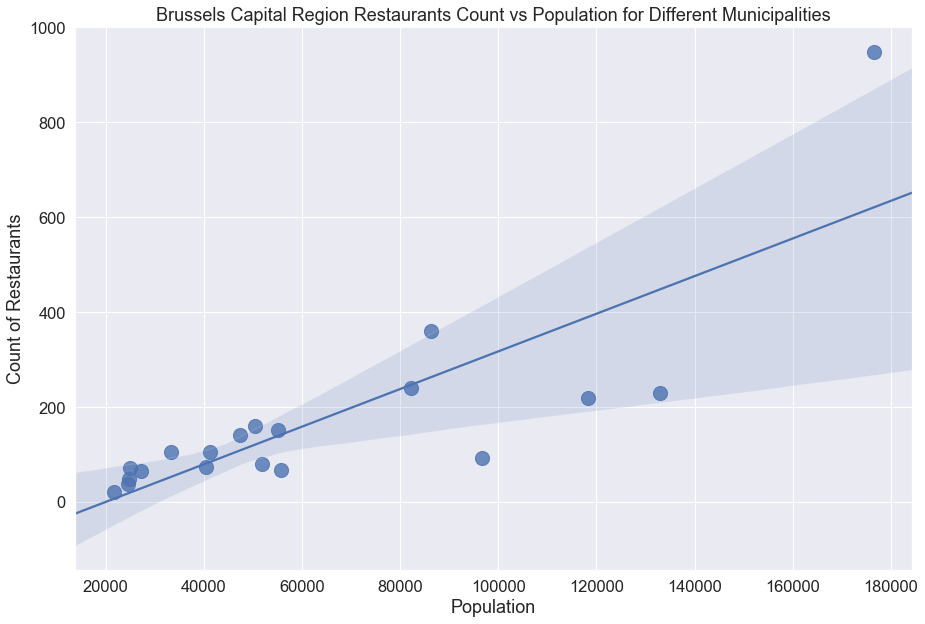

In [10]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

ax = sns.regplot(x='population', y='count', data=df_countByMuni[['population','count']].reset_index(), scatter_kws={'s': 200})
ax.set(xlabel='Population', ylabel='Count of Restaurants')
ax.set_title('Brussels Capital Region Restaurants Count vs Population for Different Municipalities')


Text(0.5, 1.0, 'Brussels Capital Region Restaurants Count vs Area for Different Municipalities')

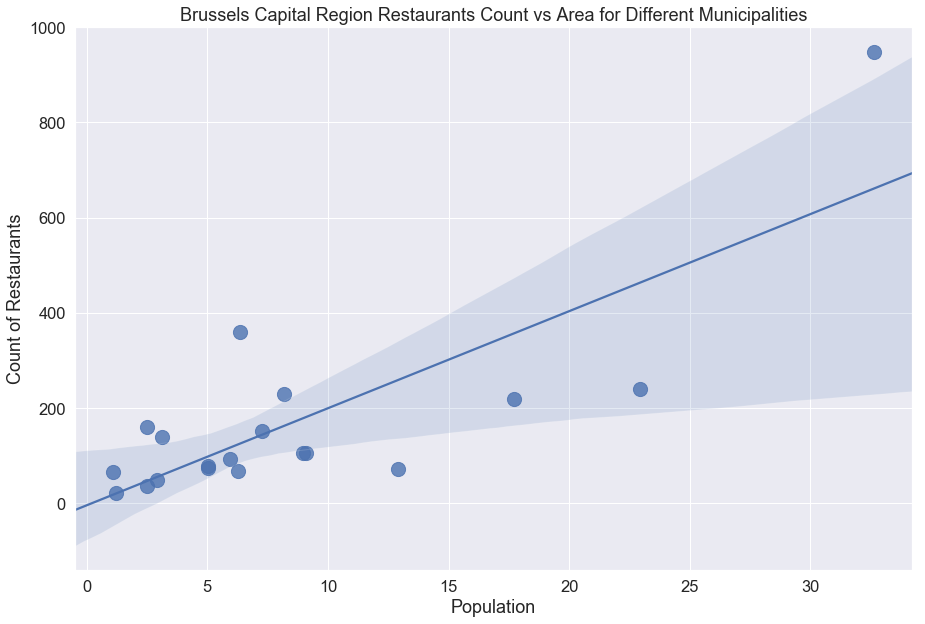

In [11]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

ax = sns.regplot(x='area', y='count', data=df_countByMuni[['area','count']].reset_index(), scatter_kws={'s': 200})
ax.set(xlabel='Population', ylabel='Count of Restaurants')
ax.set_title('Brussels Capital Region Restaurants Count vs Area for Different Municipalities')


The restaurant count per municipality:

<Figure size 1080x720 with 0 Axes>

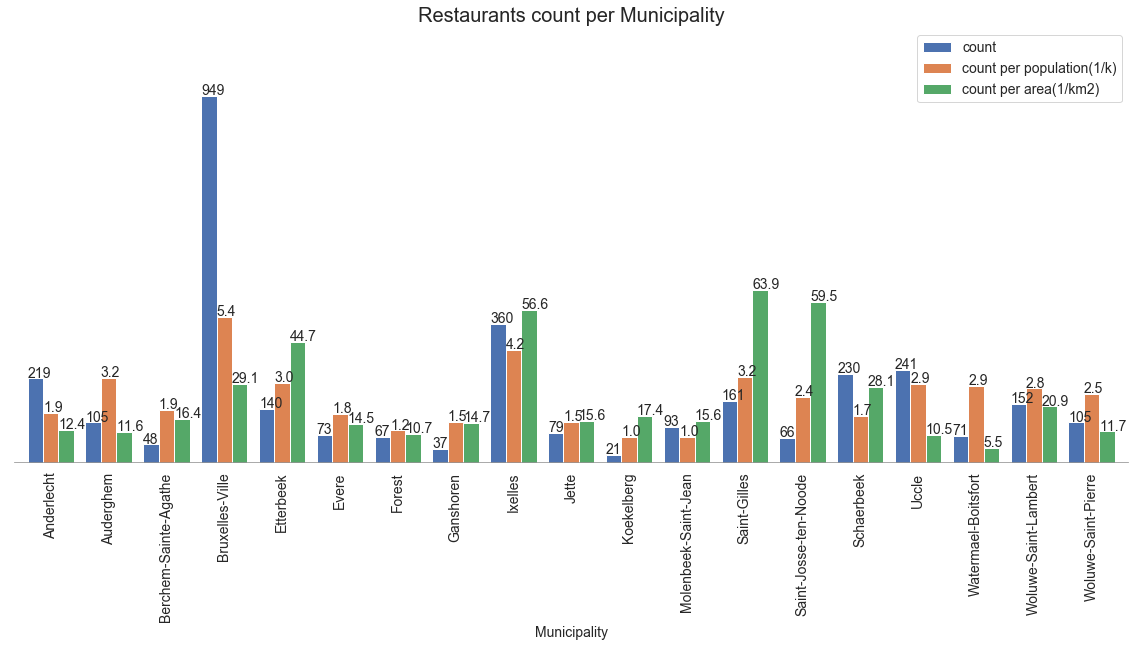

In [12]:
import numpy as np

plt.figure(figsize=(15,10))

ax=df_countByMuni[['municipality', 'count', 'count per population(1/k)', 'count per area(1/km2)']].set_index('municipality').plot(kind='bar', width=0.8, figsize=(20,8))
ax.set_title('Restaurants count per Municipality', fontsize=20)
ax.set_xlabel('Municipality', fontsize=14)

ax.set_fc('None')
ax.set_yticks([])
ax.tick_params('x',labelsize=14)
ax.axhline(color='grey')
ax.legend(facecolor='None', fontsize=14)
rect=ax.patches

arr=np.array([[rect[r*19+i].get_height() for i in range(19)] for r in range(3)])

arr_p=arr/(arr.mean(1)[:,None])*150



for r in range(3):
    for i in range(19):
        label=round(rect[r*19+i].get_height(),1) # Get the value for label before it is scaled for plot
        
        rect[r*19+i].set_height(arr_p[r,i])  # Scale for plot
        ax.text(rect[r*19+i].get_x(), rect[r*19+i].get_y()+rect[r*19+i].get_height()+2, "{}".format(label), fontsize=14)
        

In [13]:
pd.DataFrame({'Restaurant count per municipality':['count', 'count per population (1/k)', 'count per area (1/km2)'], 'avg': list(arr.mean(1))})

Restaurant count per municipality         avg
0                             count  169.315789
1        count per population (1/k)    2.413389
2            count per area (1/km2)   24.174397

The data indeed show greater restaurant count if the poplulation and/or area is greater. In average, there are 2.4 restaurants per 1000 population for each municipality; 24.2 per area of km2. Koekelberg	and Molenbeek-Saint-Jean seem to have lower than trend count. Bruxelles-Ville and Ixelles seem to have greater than trend count. This may be due to economic conditions in different municipalities.

Saint-Gilles and Saint-Josse-ten-Noode show quite dense restaurants in their area, 63.9 per km2 and 59.5 per km2. However, only in-trend number of restaurants per 1000 potential customers. This implies that even though it feels there are many restaurants when we look around in that region. But still, the competition may not be as saturated as some other municipalites. Of course, the data show these two municipalities have the greatest population density.

It will be interesting to know how economic condition, as measured by income level per capita, will affect the restaurant distribution. Combining information about density of restaurants and income level may indicate how profitable each restaurant is. It may provide insight into whether or not a particular market is saturated or under served.  

In [14]:
df_muni.head()

municipality           Dutch name             postcode  \
0             Anderlecht           Anderlecht                 1070   
1              Auderghem             Oudergem                 1160   
2  Berchem-Sainte-Agathe  Sint-Agatha-Berchem                 1082   
3        Bruxelles-Ville         Stad Brussel  1000,1020,1120,1130   
4              Etterbeek            Etterbeek                 1040   

  Population(1/1/2017)                       Area Population density(km²)  \
0              118,241   17.717.7 km2 (6.8 sq mi)                   6,680   
1               33,313    09.09.0 km2 (3.5 sq mi)                   3,701   
2               24,701    02.92.9 km2 (1.1 sq mi)                   8,518   
3              176,545  32.632.6 km2 (12.6 sq mi)                   5,415   
4               47,414    03.13.1 km2 (1.2 sq mi)                  15,295   

   population    area  populationDensity  
0      118241  17.717               6680  
1       33313   9.090               3701  
2       24701   2.920               8518  
3      176545  32.632               5415  
4       47414   3.130              15295

### Research Question 2:
#### What are the top categories of restaurnts in each municipality?

In [15]:
df_restaurants_brussels.head()

vid                   name   latitude  longitude  \
47  5718fb6b498e930b29d77485           glacier lamy  50.775501   4.354569   
49  56abd8c6498eaae8293f874f             À table 🍔🍜  50.774065   4.362790   
50  4f5fd2c3e4b00cb4dfcaf272                 Burger  50.776336   4.372664   
61  533be9b3498e7c582a2e2d22             Pile poele  50.786713   4.417077   
74  4def7a001fc7e81f6da505c4  L' Entre-Pots (Uccle)  50.780449   4.325775   

   postcode         municipality        venueCategory2  
47     1180                Uccle            Restaurant  
49     1180                Uccle  Fast Food Restaurant  
50     1180                Uccle          Burger Joint  
61     1170  Watermael-Boitsfort        Sandwich Place  
74     1180                Uccle    Italian Restaurant

In [16]:
df_countByCategory=df_restaurants_brussels.groupby('venueCategory2').count().sort_values(by='vid',axis=0, ascending=False)[['vid']]

df_countByCategory.index.name='RestaurantCategory'
df_countByCategory.columns=['count']
df_countByCategory.head()

count
RestaurantCategory         
Italian Restaurant      442
Sandwich Place          280
French Restaurant       239
Restaurant              212
Fast Food Restaurant    210

<Figure size 1080x720 with 0 Axes>

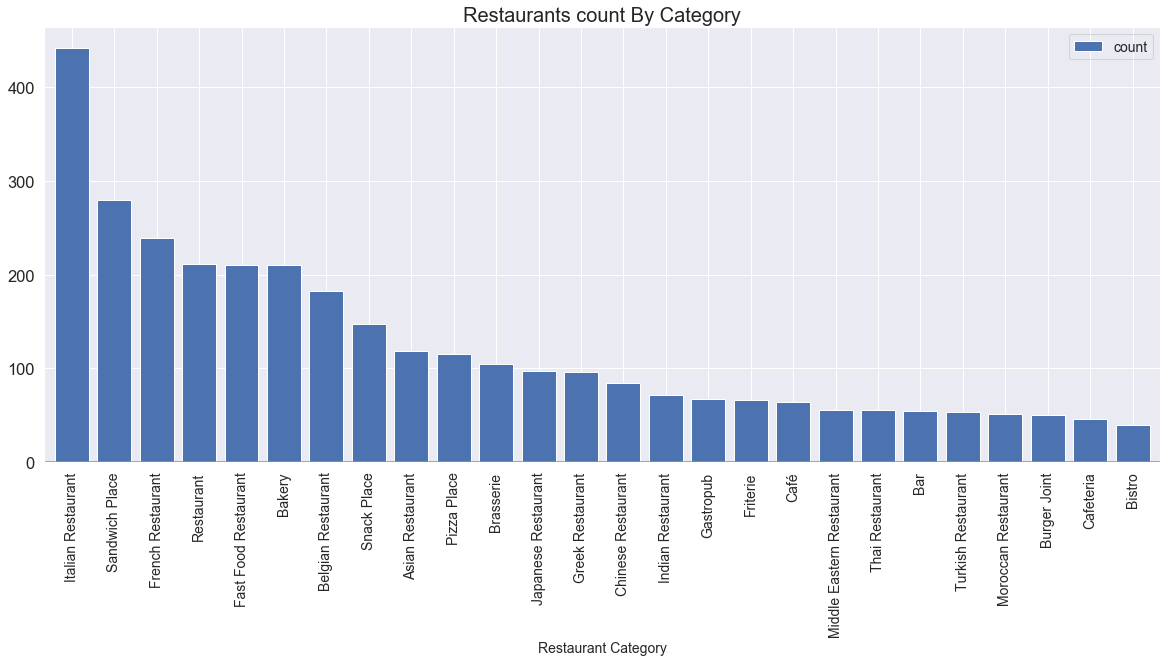

In [17]:
plt.figure(figsize=(15,10))

ax=df_countByCategory.plot(kind='bar', width=0.8, figsize=(20,8))
ax.set_title('Restaurants count By Category', fontsize=20)
ax.set_xlabel('Restaurant Category', fontsize=14)
#ax.spines['top'].set_visible(False)

ax.tick_params('x',labelsize=14)
ax.axhline(color='grey')
ax.legend(facecolor='None', fontsize=14)



Italian resaurants are most popular categorized restaurants in Brussels, followed by Sandwidch Place and French Restaurant. Category Restaurant seems refers to restaurant that are not put into any particular restaurant category, and is ranked the fourth.    

#### Top restaurants in each municipality

In [18]:
lmuni=list(df_muni['municipality'])
lcategories=list(df_restaurants_brussels['venueCategory2'].unique())
lcategories

['Restaurant',
 'Fast Food Restaurant',
 'Burger Joint',
 'Sandwich Place',
 'Italian Restaurant',
 'Belgian Restaurant',
 'Bakery',
 'Japanese Restaurant',
 'French Restaurant',
 'Cafeteria',
 'Asian Restaurant',
 'Friterie',
 'Café',
 'Bistro',
 'Thai Restaurant',
 'Chinese Restaurant',
 'Gastropub',
 'Brasserie',
 'Moroccan Restaurant',
 'Snack Place',
 'Indian Restaurant',
 'Pizza Place',
 'Greek Restaurant',
 'Turkish Restaurant',
 'Middle Eastern Restaurant',
 'Bar']

In [19]:
df_countByCategoryByMuni=df_restaurants_brussels.groupby(['municipality','venueCategory2']).count()[['vid']].sort_values(by=['municipality','vid'], ascending=[True, False])

df_topCatByMuni=pd.DataFrame([ df_countByCategoryByMuni.loc[muni].reset_index().iloc[0:5]['venueCategory2'] for muni in lmuni], index=lmuni)
df_topCatByMuni.columns=range(1,6,1)
df_topCatByMuni



1                     2  \
Anderlecht                           Bakery    Italian Restaurant   
Auderghem                Italian Restaurant                Bakery   
Berchem-Sainte-Agathe           Snack Place                Bakery   
Bruxelles-Ville          Italian Restaurant        Sandwich Place   
Etterbeek                Italian Restaurant        Sandwich Place   
Evere                              Friterie           Snack Place   
Forest                       Sandwich Place           Pizza Place   
Ganshoren                Italian Restaurant                Bakery   
Ixelles                  Italian Restaurant     French Restaurant   
Jette                                Bakery        Sandwich Place   
Koekelberg                French Restaurant  Fast Food Restaurant   
Molenbeek-Saint-Jean     Italian Restaurant  Fast Food Restaurant   
Saint-Gilles           Fast Food Restaurant    Italian Restaurant   
Saint-Josse-ten-Noode    Italian Restaurant  Fast Food Restaurant   
Schaerbeek             Fast Food Restaurant    Italian Restaurant   
Uccle                                Bakery    Italian Restaurant   
Watermael-Boitsfort       French Restaurant            Restaurant   
Woluwe-Saint-Lambert     Italian Restaurant        Sandwich Place   
Woluwe-Saint-Pierre                  Bakery     French Restaurant   

                                        3                          4  \
Anderlecht                    Snack Place                 Restaurant   
Auderghem                  Sandwich Place           Asian Restaurant   
Berchem-Sainte-Agathe    Greek Restaurant         Italian Restaurant   
Bruxelles-Ville        Belgian Restaurant          French Restaurant   
Etterbeek                          Bakery       Fast Food Restaurant   
Evere                   French Restaurant             Sandwich Place   
Forest                 Italian Restaurant         Belgian Restaurant   
Ganshoren              Belgian Restaurant                   Friterie   
Ixelles                    Sandwich Place       Fast Food Restaurant   
Jette                         Snack Place         Italian Restaurant   
Koekelberg                     Restaurant                     Bakery   
Molenbeek-Saint-Jean               Bakery             Sandwich Place   
Saint-Gilles            French Restaurant             Sandwich Place   
Saint-Josse-ten-Noode      Sandwich Place  Middle Eastern Restaurant   
Schaerbeek                         Bakery             Sandwich Place   
Uccle                   French Restaurant                 Restaurant   
Watermael-Boitsfort    Italian Restaurant                  Cafeteria   
Woluwe-Saint-Lambert               Bakery       Fast Food Restaurant   
Woluwe-Saint-Pierre    Italian Restaurant                 Restaurant   

                                          5  
Anderlecht                   Sandwich Place  
Auderghem              Fast Food Restaurant  
Berchem-Sainte-Agathe   Japanese Restaurant  
Bruxelles-Ville                  Restaurant  
Etterbeek                Chinese Restaurant  
Evere                                Bakery  
Forest                          Snack Place  
Ganshoren                        Restaurant  
Ixelles                 Japanese Restaurant  
Jette                    Belgian Restaurant  
Koekelberg               Italian Restaurant  
Molenbeek-Saint-Jean     Turkish Restaurant  
Saint-Gilles               Greek Restaurant  
Saint-Josse-ten-Noode           Snack Place  
Schaerbeek                      Snack Place  
Uccle                        Sandwich Place  
Watermael-Boitsfort          Sandwich Place  
Woluwe-Saint-Lambert      French Restaurant  
Woluwe-Saint-Pierre          Sandwich Place

### Research Question 3:
#### What are the top categories of non-european restaurnts in each municipality?

Since I am mainly interested in data association between restaurants and expats. Let's look at the non-european restaurants:

Unique restaurant categories in the data

In [20]:
lcategories

['Restaurant',
 'Fast Food Restaurant',
 'Burger Joint',
 'Sandwich Place',
 'Italian Restaurant',
 'Belgian Restaurant',
 'Bakery',
 'Japanese Restaurant',
 'French Restaurant',
 'Cafeteria',
 'Asian Restaurant',
 'Friterie',
 'Café',
 'Bistro',
 'Thai Restaurant',
 'Chinese Restaurant',
 'Gastropub',
 'Brasserie',
 'Moroccan Restaurant',
 'Snack Place',
 'Indian Restaurant',
 'Pizza Place',
 'Greek Restaurant',
 'Turkish Restaurant',
 'Middle Eastern Restaurant',
 'Bar']

In [21]:
lexpatRestaurantCat=['Asian Restaurant',
 'Chinese Restaurant',
 'Indian Restaurant',
 'Japanese Restaurant',
 'Middle Eastern Restaurant',
 'Moroccan Restaurant',
 'Thai Restaurant',
 'Turkish Restaurant']

In [24]:
df_expatResurant=df_restaurants_brussels[df_restaurants_brussels['venueCategory2'].apply(lambda x:  x in lexpatRestaurantCat)]
df_expatResurant.head()

vid             name   latitude  longitude postcode  \
79   51b8bef5498e54206aa274f8      Sushi World  50.784442   4.378206     1180   
118  4e2018041838712abe629869     Allo Shangai  50.786273   4.329159     1180   
129  504f280fe4b0dde145043f69        Thaï Café  50.789274   4.375064     1180   
131  4bae0347f964a520dd7a3be3       Sushi Shop  50.789236   4.375061     1180   
143  4e3057ffc65b80dfd84a2193  Saveur De Chine  50.795784   4.417788     1170   

            municipality       venueCategory2  
79                 Uccle  Japanese Restaurant  
118                Uccle     Asian Restaurant  
129                Uccle      Thai Restaurant  
131                Uccle  Japanese Restaurant  
143  Watermael-Boitsfort   Chinese Restaurant

In [25]:
df_expatResurant=df_expatResurant.groupby(['municipality','venueCategory2']).count()[['vid']]
df_expatResurant.head()

vid
municipality venueCategory2                
Anderlecht   Asian Restaurant             6
             Chinese Restaurant           4
             Indian Restaurant            5
             Middle Eastern Restaurant    4
             Moroccan Restaurant          3

In [26]:
df_countByMuni[['municipality','count']]

municipality  count
0              Anderlecht    219
1               Auderghem    105
2   Berchem-Sainte-Agathe     48
3         Bruxelles-Ville    949
4               Etterbeek    140
5                   Evere     73
6                  Forest     67
7               Ganshoren     37
8                 Ixelles    360
9                   Jette     79
10             Koekelberg     21
11   Molenbeek-Saint-Jean     93
12           Saint-Gilles    161
13  Saint-Josse-ten-Noode     66
14             Schaerbeek    230
15                  Uccle    241
16    Watermael-Boitsfort     71
17   Woluwe-Saint-Lambert    152
18    Woluwe-Saint-Pierre    105

In [27]:
df_countByMuni[['municipality','count']].loc[df_countByMuni['municipality']=='Auderghem', 'count']
LOOKUP={ r['municipality']:r['count']   for index,r in df_countByMuni[['municipality','count']].iterrows()}
LOOKUP

{'Anderlecht': 219,
 'Auderghem': 105,
 'Berchem-Sainte-Agathe': 48,
 'Bruxelles-Ville': 949,
 'Etterbeek': 140,
 'Evere': 73,
 'Forest': 67,
 'Ganshoren': 37,
 'Ixelles': 360,
 'Jette': 79,
 'Koekelberg': 21,
 'Molenbeek-Saint-Jean': 93,
 'Saint-Gilles': 161,
 'Saint-Josse-ten-Noode': 66,
 'Schaerbeek': 230,
 'Uccle': 241,
 'Watermael-Boitsfort': 71,
 'Woluwe-Saint-Lambert': 152,
 'Woluwe-Saint-Pierre': 105}

In [28]:
df_expatResurant.reset_index(inplace=True)

df_expatResurant.columns=['municipality', 'venueCategory2', 'count']
df_expatResurant.head()

municipality             venueCategory2  count
0   Anderlecht           Asian Restaurant      6
1   Anderlecht         Chinese Restaurant      4
2   Anderlecht          Indian Restaurant      5
3   Anderlecht  Middle Eastern Restaurant      4
4   Anderlecht        Moroccan Restaurant      3

In [29]:
df_expatResurant['count%']=df_expatResurant.apply(lambda r: r['count']/LOOKUP[r['municipality']]*100, axis=1)

In [30]:
df_expatRestaurantByMuni=df_expatResurant.groupby('municipality').sum()
df_expatRestaurantByMuni.head()

count     count%
municipality                           
Anderlecht                24  10.958904
Auderghem                 25  23.809524
Berchem-Sainte-Agathe      8  16.666667
Bruxelles-Ville          193  20.337197
Etterbeek                 27  19.285714

<Figure size 1080x720 with 0 Axes>

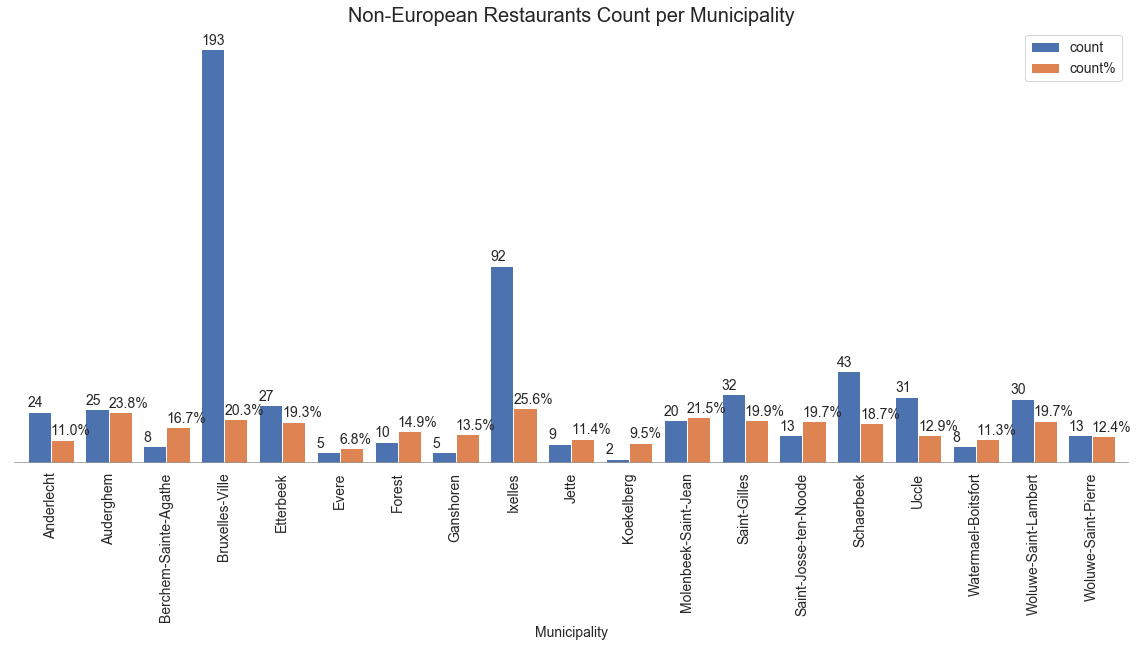

In [32]:
plt.figure(figsize=(15,10))

ax=df_expatRestaurantByMuni.plot(kind='bar', width=0.8, figsize=(20,8))
ax.set_title('Non-European Restaurants Count per Municipality', fontsize=20)
ax.set_xlabel('Municipality', fontsize=14)

ax.set_fc('None')
ax.set_yticks([])
ax.tick_params('x',labelsize=14)
ax.axhline(color='grey')
ax.legend(facecolor='None', fontsize=14)
rect=ax.patches

arr=np.array([[rect[r*19+i].get_height() for i in range(19)] for r in range(2)])

r=0
for i in range(19):
    label=round(rect[r*19+i].get_height(),1) 
        
    rect[r*19+i].set_height(arr[r,i])  
    ax.text(rect[r*19+i].get_x(), rect[r*19+i].get_y()+rect[r*19+i].get_height()+2, "{}".format(label), fontsize=14)
r=1    
for i in range(19):
    label=round(rect[r*19+i].get_height(),1) 
        
    rect[r*19+i].set_height(arr[r,i])  
    ax.text(rect[r*19+i].get_x(), rect[r*19+i].get_y()+rect[r*19+i].get_height()+2, "{}%".format(label), fontsize=14)
        



Auderghem, Bruxelles-Ville, Ixelles and Molenbeek-Saint-Jean have more (>20%) non-european restaurants than other municipalites. 

Since Bruxelles-Ville has largest population. Its percentage of non-european restaurants may indicate Belgium's general population's interest in such food, which is 20.3%. This may imply Auderghem, Ixelles and Molenbeek-Saint-Jean have more expats living in Brussels than other municipalites.

### Research Question 4:
#### Which municipalities have more Asian restaurants?

As mentioned in introduction, I am interested in knowing statistics of Japanese Restaurant. Japanese Restaurant belong to the category of Asian Restaurant. In the data, some venues are specified with Asian Restaurant subcategories, exclusive from other categories. It will be better we look at them as a whole. 

Particularly, let's consider East and Southern Asian Restaurants. The related categories in our data are:


In [33]:
lesAsianRestaurantCat=['Asian Restaurant',
 'Chinese Restaurant',
 'Indian Restaurant',
 'Japanese Restaurant',
 'Thai Restaurant']

In [34]:
df_esasiaResurant=df_restaurants_brussels[df_restaurants_brussels['venueCategory2'].apply(lambda x:  x in lesAsianRestaurantCat)]
df_esasiaResurant.head()

vid             name   latitude  longitude postcode  \
79   51b8bef5498e54206aa274f8      Sushi World  50.784442   4.378206     1180   
118  4e2018041838712abe629869     Allo Shangai  50.786273   4.329159     1180   
129  504f280fe4b0dde145043f69        Thaï Café  50.789274   4.375064     1180   
131  4bae0347f964a520dd7a3be3       Sushi Shop  50.789236   4.375061     1180   
143  4e3057ffc65b80dfd84a2193  Saveur De Chine  50.795784   4.417788     1170   

            municipality       venueCategory2  
79                 Uccle  Japanese Restaurant  
118                Uccle     Asian Restaurant  
129                Uccle      Thai Restaurant  
131                Uccle  Japanese Restaurant  
143  Watermael-Boitsfort   Chinese Restaurant

In [35]:
df_esasiaResurantByMuniByCat=df_esasiaResurant.groupby(['municipality','venueCategory2']).count()[['vid']]

In [36]:
df_esasiaResurantByMuniByCat.reset_index(inplace=True)

df_esasiaResurantByMuniByCat.columns=['municipality', 'venueCategory2', 'count']
df_esasiaResurantByMuniByCat.head()

municipality      venueCategory2  count
0   Anderlecht    Asian Restaurant      6
1   Anderlecht  Chinese Restaurant      4
2   Anderlecht   Indian Restaurant      5
3    Auderghem    Asian Restaurant      6
4    Auderghem  Chinese Restaurant      4

<Figure size 1080x720 with 0 Axes>

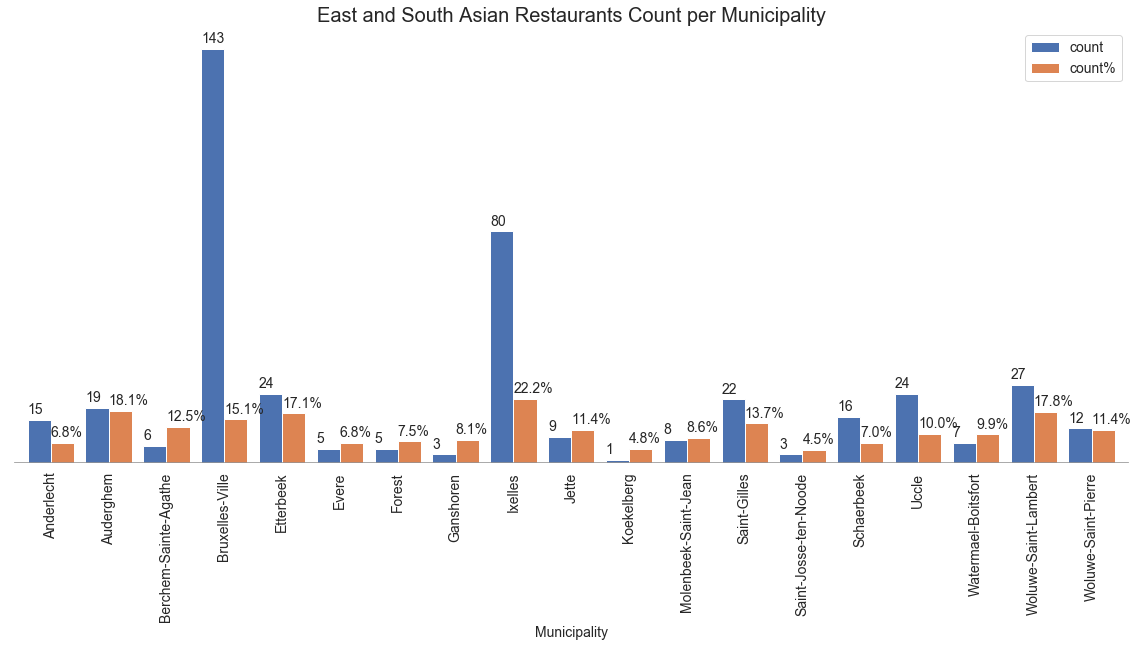

In [37]:
df_esasiaResurantByMuniByCat['count%']=df_esasiaResurantByMuniByCat.apply(lambda r: r['count']/LOOKUP[r['municipality']]*100, axis=1)
df_esasiaResurantByMuniByCat=df_esasiaResurantByMuniByCat.groupby('municipality').sum()

plt.figure(figsize=(15,10))

ax=df_esasiaResurantByMuniByCat.plot(kind='bar', width=0.8, figsize=(20,8))
ax.set_title('East and South Asian Restaurants Count per Municipality', fontsize=20)
ax.set_xlabel('Municipality', fontsize=14)

ax.set_fc('None')
ax.set_yticks([])
ax.tick_params('x',labelsize=14)
ax.axhline(color='grey')
ax.legend(facecolor='None', fontsize=14)
rect=ax.patches

arr=np.array([[rect[r*19+i].get_height() for i in range(19)] for r in range(2)])



r=0
for i in range(19):
    label=round(rect[r*19+i].get_height(),1) 

    rect[r*19+i].set_height(arr[r,i])  
    ax.text(rect[r*19+i].get_x(), rect[r*19+i].get_y()+rect[r*19+i].get_height()+2, "{}".format(label), fontsize=14)
r=1    
for i in range(19):
    label=round(rect[r*19+i].get_height(),1) 

    rect[r*19+i].set_height(arr[r,i])  
    ax.text(rect[r*19+i].get_x(), rect[r*19+i].get_y()+rect[r*19+i].get_height()+2, "{}%".format(label), fontsize=14)



If we only consider East and South Asian Restaurants, Molenbeek-Saint-Jean is no longer the top municipality. Auderghem and Ixelles in addition to Bruxelles-Ville are still the top municipalites. Etterbeek and Woluwe-Saint-Lambert are another municipalities that have more East Souther Asian Restaurant count percentage than the benchmark, Bruxelles-Ville.

This may imply East Southern Asian expats may have larger portion of population in Auderghem, Ixelles, Etterbeek and Woluwe-Saint-Lambert than the benchmark. Molenbeek-Saint-Jean may have more non-East-Southern expats.

In [38]:
df_esasiaResurantByMuniByCat

count     count%
municipality                           
Anderlecht                15   6.849315
Auderghem                 19  18.095238
Berchem-Sainte-Agathe      6  12.500000
Bruxelles-Ville          143  15.068493
Etterbeek                 24  17.142857
Evere                      5   6.849315
Forest                     5   7.462687
Ganshoren                  3   8.108108
Ixelles                   80  22.222222
Jette                      9  11.392405
Koekelberg                 1   4.761905
Molenbeek-Saint-Jean       8   8.602151
Saint-Gilles              22  13.664596
Saint-Josse-ten-Noode      3   4.545455
Schaerbeek                16   6.956522
Uccle                     24   9.958506
Watermael-Boitsfort        7   9.859155
Woluwe-Saint-Lambert      27  17.763158
Woluwe-Saint-Pierre       12  11.428571

### Research Question 5:
#### What about Japanese Restaurant?

My incentive to conduct this analysis was to know more about Japanese restaurants in Auderghem because it was reported that large population of Japanese expats live in Auderghem. 

However, from the analysis performed, I realized there are flaws in my analysis. Several are:

1. Some restaurant venues are categorized as Asian Restaurant as primary category, which means it is not specified as one of many subcategories of Asian Restaurants. Foursquare may have more venue details to provide such information. But it is beyond the scope of this work.

2. After glancing the data when performing analysis, I found that restaurants with Japanese-related name are categorized as Seafood Restaurant. Foursquare may have more venue details to provide such information. But it is beyond the scope of this work.

3. As it can be seen in the analysis performed, Auderghem does not have many restaurnt venue information provided by Foursquare: 105 in total restaurant venues excluding those categories with fewer than 50 venues in Brussels Capital Region as whole, 25 for non-european restaurants, 19 for East Southern Asian Restaurants. The statistics population is not very large to draw much meaningful information, especially considering data are obscured by the previous two factors.

As a result, the final analysis of this work is to perform clustering analysis of Asian Restaurants in Brussels Capital Region.

### Asian Restaurant Venue Clustering  in Brussels Capital Region

Prepare data for KMeans clustering analysis

In [40]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

google_api_key=''

def lonlat_to_xy(lon, lat): 
    '''convert (longitude, latitude) of WGS84 spherical coordinate system to (x,y coordinates in metters) of UTM Cartesian coordinate.'''
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def get_coordinates(address, api_key=google_api_key, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except Exception as eObj:
        print(str(eObj))
        return [None, None]

In [41]:
df_esasiaResurant.head()

vid             name   latitude  longitude postcode  \
79   51b8bef5498e54206aa274f8      Sushi World  50.784442   4.378206     1180   
118  4e2018041838712abe629869     Allo Shangai  50.786273   4.329159     1180   
129  504f280fe4b0dde145043f69        Thaï Café  50.789274   4.375064     1180   
131  4bae0347f964a520dd7a3be3       Sushi Shop  50.789236   4.375061     1180   
143  4e3057ffc65b80dfd84a2193  Saveur De Chine  50.795784   4.417788     1170   

            municipality       venueCategory2  
79                 Uccle  Japanese Restaurant  
118                Uccle     Asian Restaurant  
129                Uccle      Thai Restaurant  
131                Uccle  Japanese Restaurant  
143  Watermael-Boitsfort   Chinese Restaurant

In [42]:
XY=df_esasiaResurant.apply(lambda r: lonlat_to_xy(r['latitude'], r['longitude']), axis=1).values
    

XY=[  [coord[0], coord[1]] for coord in XY]

In [43]:
from sklearn.cluster import KMeans

num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(XY)
labels = k_means.labels_

print(labels)

[1 1 1 1 2 1 1 2 2 2 1 1 1 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 4 4 4 1 1 1 4 4 4
 4 4 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 2 2 2 3 1 1 1 1 4 4 4 4
 4 4 2 2 2 2 2 2 3 3 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 3 3 3 0 0 0 0 0 0 0 4 4 0 4
 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 0 0 0 0 0 0 0 0 0
 0 0 0 4 4 4 4 2 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 4 4 4 4 4 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 2
 2 0 0 0 3 3 3 3 3 0 0 0 0 4 4 4 3 3 0 4 3 3 3 3 3 3 4 3 3 3 3 3 3 3 0 0 3
 3 3 3 3 3 3 3 3 3 0 0 0 3 3 0 3 3 3 3 3 0 3]


In [44]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors


auderghem_coord=(50.8164064, 4.4265181)
ixelles_coord=(50.83334319999999, 4.3666294)
etterbeek_coord=(50.832578, 4.3889939)
woluwe_saint_lambert_coord=(50.8489094, 4.4320883)
brussels_coord = (50.8503463, 4.3517211)
brussels_ville_coord=(50.8503396, 4.3517103)

#print('Coordinate of {}: {}'.format(brussels_address, brussels_coord))

map_brussels = folium.Map(location=brussels_coord, zoom_start=12)

x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(df_esasiaResurant['latitude'], df_esasiaResurant['longitude'], labels):
    #label = folium.Popup(str(cat) + ' Cluster ' + str(cluster), parse_html=True)
    #print(shopname, lat, lon, rainbow[cluster-1])
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_brussels)


style = {'fillColor': '#00000000', 'color': 'red', 'weight': 1}
folium.GeoJson(brusselsMuniGeojson, style_function=lambda x: style).add_to(map_brussels)

folium.Marker(auderghem_coord, popup='Auderghem').add_to(map_brussels)
folium.Marker(ixelles_coord, popup='Ixelles').add_to(map_brussels)
folium.Marker(etterbeek_coord, popup='Etterbeek').add_to(map_brussels)
folium.Marker(woluwe_saint_lambert_coord, popup='Woluwe-Saint-Lambert').add_to(map_brussels)
folium.Marker(brussels_coord, popup='Burssels').add_to(map_brussels)
folium.Marker(brussels_ville_coord, popup='Burssels Ville').add_to(map_brussels)






map_brussels

5 clusters of East Southern Asian restaurants are shown in the map. Also shown are labels for Auderghem, Ixelles, Etterbeek, Wolue-Saint-Lambert, and Brussels. Indeed, in those regions, greater density of restaurants of interest is seen.

## V. Conclusion

Categorial descriptive statistical analysis has been performed to understand the association between population and restaurants, using data collected from Foursqaure.com API, Google MAP API, and wikipedia for Brussels Capital Region. In general, there is obvious association between number of restaurants and population. For municipality with larger population, there tends to be more restaurants as data show. Some municipalities have above or below trend restaurant count per population. The reason for that may be the economic condition, i.e. income level. Another reason may be the population is either under-served or restaurants are over-crowded. Answering such questions require more information about economic condition of the municipalities. It is beyond what the collected data can be drawn conclusion upond.

The fact I am interested in Auderghem than any other municipalities is a hint that Auderghem may be a municipality with larger expat population, in general, than other municipalities in Brussels. The data indeed imply such. However, the collected data is obscure to provide more affirmative information to conclude that more Japanese restaurants in Auderghem as a result of large Japanese expat population. Some potential reasons were discussed in the Results and Discussion section. Querying more details of venue information from Foursquare API may provide further clarification.

Data collected for this work is through interent. Such approach is cheap and even free. However, it does not mean it is easy. An attempt has been made to establish a methodology to undertand, collect, and prepare the data for better analysis. To achieve better confidence in such an approach, further investigation is required.



